## Set up some variables for the local directories we'll work in for this task

In [1]:
base_dir='/tmp'
dataset_name = 'fish_species'
dataset_dir = base_dir + '/' + dataset_name

%env BASE_DIR=$base_dir
%env DATASET_DIR=$dataset_dir
%env DATASET_NAME=$dataset_name

env: BASE_DIR=/tmp
env: DATASET_DIR=/tmp/fish_species
env: DATASET_NAME=fish_species


## Grab a bunch of images grouped by folders, one per label class

In [2]:
%%bash
rm -rf $DATASET_DIR
mkdir -p $DATASET_DIR
cd $DATASET_DIR
wget 'https://www.dropbox.com/s/8d8u6etdxip1wu2/subset_images.zip?dl=1' --quiet
unzip "subset_images.zip?dl=1"
mv subset_images/* .
rm -rf subset_images
rm "subset_images.zip?dl=1"

Archive:  subset_images.zip?dl=1
   creating: subset_images/albacore/
  inflating: subset_images/albacore/_JDP4898.jpg.8b862546076c882c9061bc8b4a25375d.jpg  
  inflating: subset_images/albacore/_MG_0421-439JPG.jpg  
  inflating: subset_images/albacore/0385718c-44ba-4645-b2b0-6071f6bba63a-false_albacore.jpg  
  inflating: subset_images/albacore/04-dwskok_dsc_7715.jpg  
  inflating: subset_images/albacore/103-preserving-tuna-tuna.jpg  
  inflating: subset_images/albacore/106.15-Thu.ala_.IN00764.rgb_.72.20H.jpg  
  inflating: subset_images/albacore/10742756-albacore-tuna-fish-thunnus-alalunga-underwater-ocean.jpg  
  inflating: subset_images/albacore/10915376-16x9-large.jpg  
  inflating: subset_images/albacore/11057898-albacore-tuna-thunnus-alalunga-fish-isolated-on-white.jpg  
  inflating: subset_images/albacore/11058004-albacore-thunnus-alalunga-fish-between-bluefin-tuna-school.jpg  
  inflating: subset_images/albacore/114-Preparation-tuna2.jpg  
  inflating: subset_images/albacore/120

### See what classes of data we have from our data set

In [3]:
! ls $DATASET_DIR

albacore	    australian_salmon  bream	 flounder  snapper
australian_herring  big eye tuna       flathead  gurnard   yellowtail_kingfish


### Look at a few example images from some of our classes

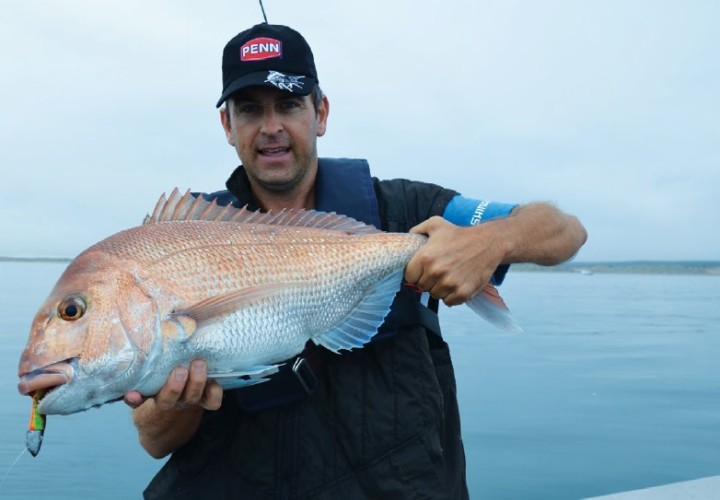

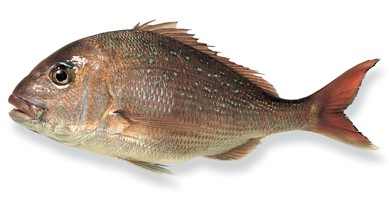

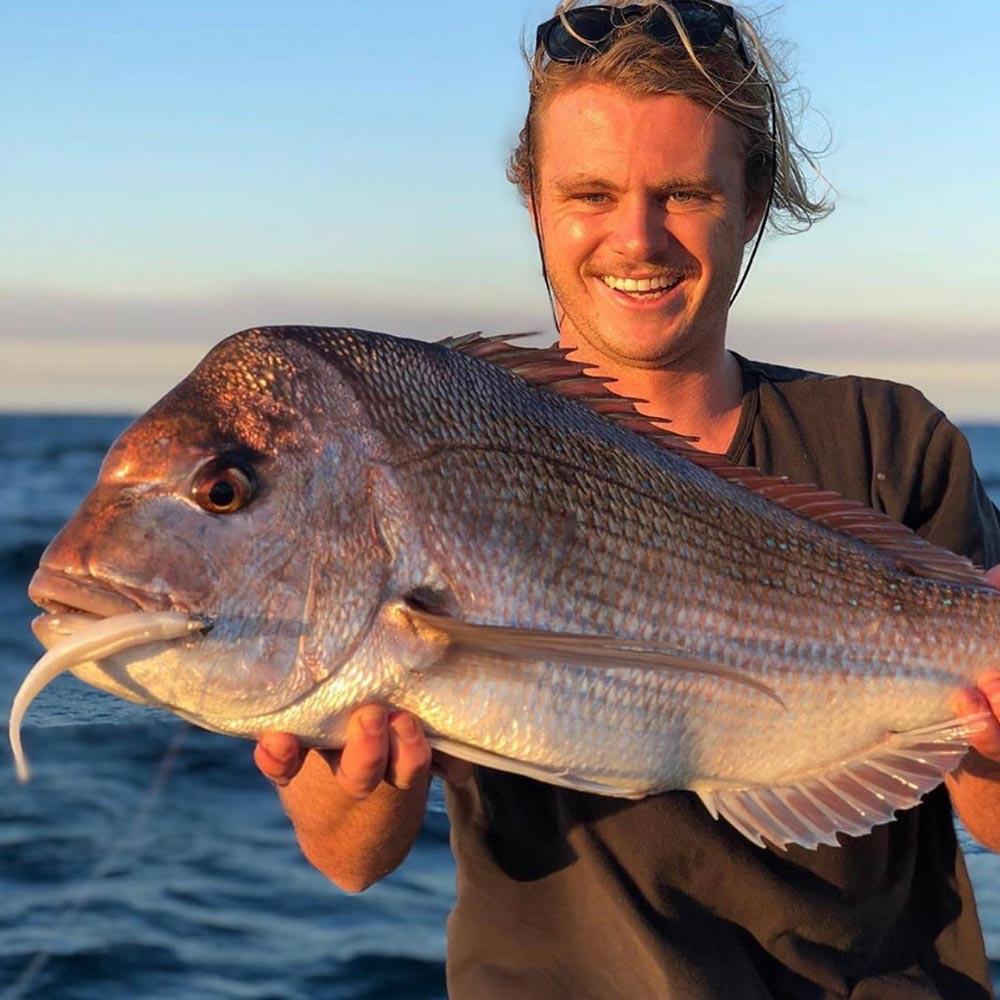

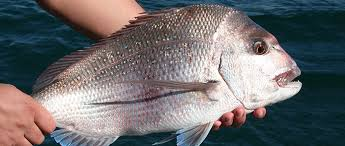

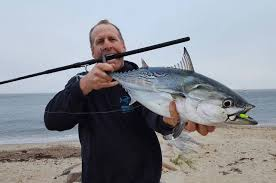

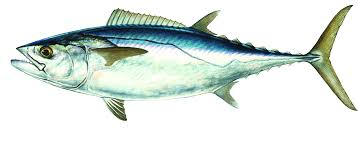

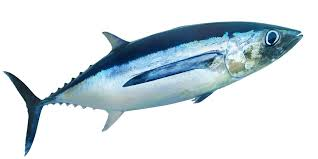

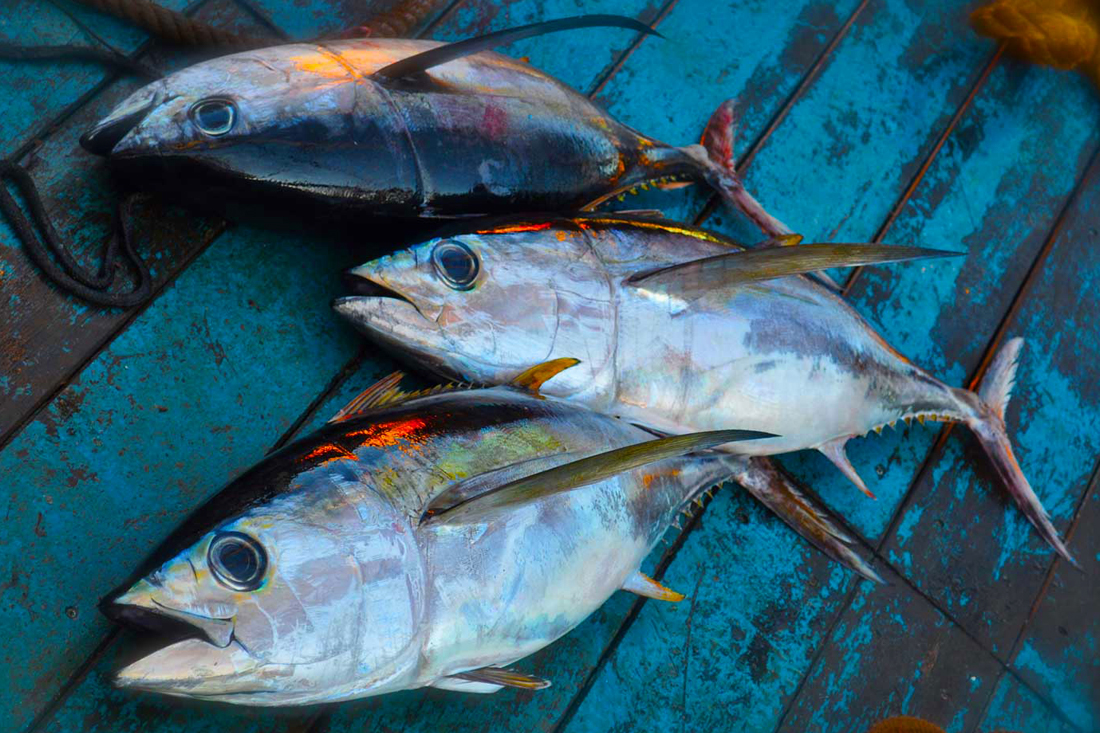

In [4]:
import os
from IPython.display import display, Image, DisplayObject

def show_thumbnails(path, num):
    names = [f for f in os.listdir(path) if f.endswith('.png') or f.endswith('jpg')]
    for name in names[:num]:
        display(Image(filename=path + '/' + name, width=100))
        
show_thumbnails(dataset_dir + '/snapper', 4)
show_thumbnails(dataset_dir + '/albacore', 4)

## Set up some variables for Sagemaker

In [5]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

role = get_execution_role()
sess = sagemaker.Session()

training_image = get_image_uri(sess.boto_region_name, 'image-classification', repo_version="latest")

In [6]:
sess.boto_region_name

'ap-southeast-2'

## Preparing data for our model

In [7]:
# Find im2rec in our environment and set up some other vars in our environemnt
import sys,os

suffix='/mxnet/tools/im2rec.py'
im2rec = list(filter( (lambda x: os.path.isfile(x + suffix )), sys.path))[0] + suffix
%env IM2REC=$im2rec

env: IM2REC=/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/tools/im2rec.py


In [8]:
# Resize images to 224x224
# Sometimes, our input images aren't already in the desired format for training. I like to format all my images to be the correct size before I train my model.

from PIL import Image
import os
import sys

def resize(filepath, size=224, fill_color=(0, 0, 0, 0)):
    try:
        image = Image.open(filepath)
    except:
        os.remove(filepath)
        return

    new_im = Image.new('RGB', (size, size), fill_color)
    image.thumbnail([size, size])
    (w, h) = image.size
    new_im.paste(image, (int((size - w) / 2), int((size - h) / 2 )))

    # Overwrite file with resized version
    new_im.save(filepath, "JPEG", quality = 95)

def recursively_process_files(dirname, processing_func):
    for dirname, dirnames, filenames in os.walk(dirname):
        for subdirname in dirnames:
            recursively_process_files(subdirname, processing_func)
 
        for filename in filenames:
            processing_func(os.path.join(dirname, filename))


recursively_process_files(f"{dataset_dir}", resize)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/PIL/Image.py:918: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


In [9]:
%%bash
# Use the IM2REC script to convert our images into RecordIO files

cd $BASE_DIR

rm ${DATASET_NAME}_classes

# First we need to create two LST files (training and test lists), noting the correct label class for each image
# We'll also save the output of the LST files command, since it includes a list of all of our label classes
echo "Creating LST files"
python $IM2REC --list --recursive --pass-through --test-ratio=0.3 --train-ratio=0.7 $DATASET_NAME $DATASET_NAME > ${DATASET_NAME}_classes

# Then we create RecordIO files from the LST files
echo "Creating RecordIO files"
rm *.rec
python $IM2REC --num-thread=4 ${DATASET_NAME}_train.lst $DATASET_NAME
python $IM2REC --num-thread=4 ${DATASET_NAME}_test.lst $DATASET_NAME
ls -lh *.rec

Creating LST files
Creating RecordIO files
Creating .rec file from /tmp/fish_species_train.lst in /tmp
time: 0.02089977264404297  count: 0
time: 1.105412483215332  count: 1000
Creating .rec file from /tmp/fish_species_test.lst in /tmp
time: 0.004642486572265625  count: 0
-rw-rw-r-- 1 ec2-user ec2-user 11M Jun  8 12:17 fish_species_test.rec
-rw-rw-r-- 1 ec2-user ec2-user 24M Jun  8 12:17 fish_species_train.rec


rm: cannot remove ‘fish_species_classes’: No such file or directory
rm: cannot remove ‘*.rec’: No such file or directory


In [10]:
# Get the list of class labels into a python variable to use later
classes_file_name = dataset_name + '_classes'
path = base_dir + '/' + classes_file_name
class_labels = ! cut -d " " -f1 {path} | paste -sd " "
class_labels = class_labels[0].split(' ')

# Show a few of them now just so we can see the kind of labels we're working with...
class_labels[0:10]

['albacore',
 'australian_herring',
 'australian_salmon',
 'big',
 'bream',
 'flathead',
 'flounder',
 'gurnard',
 'snapper',
 'yellowtail_kingfish']

In [11]:
# Upload our train and test RecordIO files to S3 in the bucket that our sagemaker session is using
bucket = sess.default_bucket()

s3train_path = 's3://{}/{}/train/'.format(bucket, dataset_name)
s3validation_path = 's3://{}/{}/validation/'.format(bucket, dataset_name)

# Clean up any existing data in our training s3 bucket
!aws s3 rm s3://{bucket}/{dataset_name}/train --recursive
!aws s3 rm s3://{bucket}/{dataset_name}/validation --recursive

# Upload the rec files to the train and validation channels
!aws s3 cp /tmp/{dataset_name}_train.rec $s3train_path
!aws s3 cp /tmp/{dataset_name}_test.rec $s3validation_path

delete: s3://sagemaker-ap-southeast-2-594822412489/fish_species/train/fish_species_train.rec
delete: s3://sagemaker-ap-southeast-2-594822412489/fish_species/validation/fish_species_test.rec
upload: ../../../../../tmp/fish_species_train.rec to s3://sagemaker-ap-southeast-2-594822412489/fish_species/train/fish_species_train.rec
upload: ../../../../../tmp/fish_species_test.rec to s3://sagemaker-ap-southeast-2-594822412489/fish_species/validation/fish_species_test.rec


### Configuring the data for our model training to use


In [12]:
train_data = sagemaker.session.s3_input(
    s3train_path, 
    distribution='FullyReplicated', 
    content_type='application/x-recordio', 
    s3_data_type='S3Prefix'
)

validation_data = sagemaker.session.s3_input(
    s3validation_path, 
    distribution='FullyReplicated', 
    content_type='application/x-recordio', 
    s3_data_type='S3Prefix'
)

data_channels = {'train': train_data, 'validation': validation_data}

## Training

### Training Setup

In [13]:
s3_output_location = 's3://{}/{}/output'.format(bucket, dataset_name)
image_classifier = sagemaker.estimator.Estimator(
    training_image,
    role, 
    train_instance_count=1, 
    train_instance_type='ml.p2.xlarge',
    output_path=s3_output_location,
    sagemaker_session=sess,
    train_use_spot_instances=True,
    train_max_wait=60*60,
    train_max_run=60*60,
)

In [14]:
num_classes=! ls -l {base_dir}/{dataset_name} | wc -l
num_classes=int(num_classes[0]) - 1

num_training_samples=! cat {base_dir}/{dataset_name}_train.lst | wc -l
num_training_samples = int(num_training_samples[0])

# Learn more about the Sagemaker built-in Image Classifier hyperparameters here: https://docs.aws.amazon.com/sagemaker/latest/dg/IC-Hyperparameter.html

# These hyperparameters we won't want to change, as they define things like
# the size of the images we'll be sending for input, the number of training classes we have, etc.
base_hyperparameters=dict(
    use_pretrained_model=1,
    image_shape='3,224,224',
    num_classes=num_classes,
    num_training_samples=num_training_samples,
)

# These are hyperparameters we may want to tune, as they can affect the model training success:
hyperparameters={
    **base_hyperparameters, 
    **dict(
        epochs=60,
        learning_rate=0.001,
        mini_batch_size=8,
        early_stopping=True,
    )
}


image_classifier.set_hyperparameters(**hyperparameters)

hyperparameters

{'use_pretrained_model': 1,
 'image_shape': '3,224,224',
 'num_classes': 10,
 'num_training_samples': 1401,
 'epochs': 60,
 'learning_rate': 0.001,
 'mini_batch_size': 8,
 'early_stopping': True}

### Start the training
This will take some time because it's provisioning a new container runtime to train our model, then the actual training happens, then the trained model gets uploaded to S3 and the container is shut down.

In [15]:
%%time

image_classifier.fit(inputs=data_channels, logs=True)

job = image_classifier.latest_training_job
model_path = f"{base_dir}/{job.name}"

print(f"\n\n Finished training! The model is available for download at: {image_classifier.output_path}/{job.name}/output/model.tar.gz")

2020-06-08 12:19:34 Starting - Starting the training job...
2020-06-08 12:19:36 Starting - Launching requested ML instances......
2020-06-08 12:20:45 Starting - Preparing the instances for training.........
2020-06-08 12:22:35 Downloading - Downloading input data
2020-06-08 12:22:35 Training - Downloading the training image......
2020-06-08 12:23:28 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
[06/08/2020 12:23:31 INFO 140184818558784] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/image_classification/default-input.json: {u'beta_1': 0.9, u'gamma': 0.9, u'beta_2': 0.999, u'optimizer': u'sgd', u'use_pretrained_model': 0, u'eps': 1e-08, u'epochs': 30, u'lr_scheduler_factor': 0.1, u'num_layers': 152, u'image_shape': u'3,224,224', u'precision_dtype': u'float32', u'mini_batch_size': 32, u'weight_decay': 0.0001, u'learning_rate': 0.1, u'momentum': 0}
[06/08/2020 12:23:31 INFO 140184818558784] M

[06/08/2020 12:27:58 INFO 140184818558784] Epoch[2] Batch [120]#011Speed: 16.497 samples/sec#011accuracy=0.950413
[06/08/2020 12:28:08 INFO 140184818558784] Epoch[2] Batch [140]#011Speed: 16.504 samples/sec#011accuracy=0.951241
[06/08/2020 12:28:17 INFO 140184818558784] Epoch[2] Batch [160]#011Speed: 16.511 samples/sec#011accuracy=0.951863
[06/08/2020 12:28:24 INFO 140184818558784] Epoch[2] Train-accuracy=0.952143
[06/08/2020 12:28:24 INFO 140184818558784] Epoch[2] Time cost=84.284
[06/08/2020 12:28:36 INFO 140184818558784] Epoch[2] Validation-accuracy=0.911667
[06/08/2020 12:28:37 INFO 140184818558784] Storing the best model with validation accuracy: 0.911667
[06/08/2020 12:28:37 INFO 140184818558784] Saved checkpoint to "/opt/ml/model/image-classification-0003.params"
[06/08/2020 12:28:47 INFO 140184818558784] Epoch[3] Batch [20]#011Speed: 16.292 samples/sec#011accuracy=0.964286
[06/08/2020 12:28:57 INFO 140184818558784] Epoch[3] Batch [40]#011Speed: 16.427 samples/sec#011accuracy=0.

[06/08/2020 12:37:53 INFO 140184818558784] Epoch[8] Batch [140]#011Speed: 16.315 samples/sec#011accuracy=0.993794
[06/08/2020 12:38:03 INFO 140184818558784] Epoch[8] Batch [160]#011Speed: 16.342 samples/sec#011accuracy=0.993789
[06/08/2020 12:38:09 INFO 140184818558784] Epoch[8] Train-accuracy=0.994286
[06/08/2020 12:38:09 INFO 140184818558784] Epoch[8] Time cost=85.104
[06/08/2020 12:38:22 INFO 140184818558784] Epoch[8] Validation-accuracy=0.921667
[06/08/2020 12:38:32 INFO 140184818558784] Epoch[9] Batch [20]#011Speed: 16.283 samples/sec#011accuracy=0.982143
[06/08/2020 12:38:42 INFO 140184818558784] Epoch[9] Batch [40]#011Speed: 16.409 samples/sec#011accuracy=0.990854
[06/08/2020 12:38:52 INFO 140184818558784] Epoch[9] Batch [60]#011Speed: 16.448 samples/sec#011accuracy=0.989754
[06/08/2020 12:39:01 INFO 140184818558784] Epoch[9] Batch [80]#011Speed: 16.470 samples/sec#011accuracy=0.990741
[06/08/2020 12:39:11 INFO 140184818558784] Epoch[9] Batch [100]#011Speed: 16.477 samples/sec#0

[06/08/2020 12:48:06 INFO 140184818558784] Epoch[14] Validation-accuracy=0.911667
[06/08/2020 12:48:16 INFO 140184818558784] Epoch[15] Batch [20]#011Speed: 16.276 samples/sec#011accuracy=1.000000
[06/08/2020 12:48:26 INFO 140184818558784] Epoch[15] Batch [40]#011Speed: 16.420 samples/sec#011accuracy=0.984756
[06/08/2020 12:48:36 INFO 140184818558784] Epoch[15] Batch [60]#011Speed: 16.448 samples/sec#011accuracy=0.989754
[06/08/2020 12:48:45 INFO 140184818558784] Epoch[15] Batch [80]#011Speed: 16.475 samples/sec#011accuracy=0.986111
[06/08/2020 12:48:55 INFO 140184818558784] Epoch[15] Batch [100]#011Speed: 16.489 samples/sec#011accuracy=0.988861
[06/08/2020 12:49:05 INFO 140184818558784] Epoch[15] Batch [120]#011Speed: 16.491 samples/sec#011accuracy=0.989669
[06/08/2020 12:49:15 INFO 140184818558784] Epoch[15] Batch [140]#011Speed: 16.496 samples/sec#011accuracy=0.991135
[06/08/2020 12:49:24 INFO 140184818558784] Epoch[15] Batch [160]#011Speed: 16.500 samples/sec#011accuracy=0.992236
[0

## Converting our SageMaker-trained model to the ONNX Format

SageMaker uses a framework called MXNet to train and produce our image classifier model.  But, we might want to use this model to perform inference somehwere that MXNet doesn't easily run, such as in a web browser.  

ONNX is an open format to represent deep learning models. With ONNX, AI developers can more easily move models between state-of-the-art tools and choose the combination that is best for them. More info at https://onnx.ai/

SageMaker provides helpful tooling in the Python SDK to convert trained models to the ONNX format, making it easy to take your trained model, convert it to ONNX, then use that model in whatever environment you want to (as long as that environment will accept models in the ONNX format).

In [16]:
# Get the path where our trained model was saved to S3
model_s3_path = image_classifier.model_data
model_s3_output_dir = "/".join(model_s3_path.split('/')[0:-1])
%env MODEL_S3_PATH = $model_s3_path

env: MODEL_S3_PATH=s3://sagemaker-ap-southeast-2-594822412489/fish_species/output/image-classification-2020-06-08-12-19-34-811/output/model.tar.gz


In [17]:
%%bash

# Download our model and extract it into $BASE_DIR/downloaded_model
rm -rf $BASE_DIR/downloaded_model/
mkdir -p $BASE_DIR/downloaded_model/
aws s3 cp $MODEL_S3_PATH $BASE_DIR/downloaded_model/model.tar.gz
cd $BASE_DIR/downloaded_model
tar -xzvf model.tar.gz

download: s3://sagemaker-ap-southeast-2-594822412489/fish_species/output/image-classification-2020-06-08-12-19-34-811/output/model.tar.gz to ../../../../../tmp/downloaded_model/model.tar.gz
image-classification-symbol.json
image-classification-0013.params
model-shapes.json


In [18]:
# Use MXNet's onnx_mxnet module to convert the MXNet model that SageMaker trained into ONNX format
from mxnet.contrib import onnx as onnx_mxnet
from glob import glob
import numpy as np

model_dir = base_dir + "/downloaded_model"

model_symbol_file = glob(model_dir + "/*symbol.json")[0]
model_params_file = glob(model_dir + "/*.params")[0]

onnx_mxnet.export_model(sym=model_symbol_file,
                            params=model_params_file,
                            input_shape=[(1, 3, 224, 224)],
                            input_type=np.float32,
                            onnx_file_path="{}/model.onnx".format(model_dir),
                            verbose=True)

# And upload the ONNX model back to the same place on S3 as where we Sagemaker put the MXNet version of the model, just for safe-keeping
! aws s3 cp {model_dir}/model.onnx {model_s3_output_dir}/model.onnx

upload: ../../../../../tmp/downloaded_model/model.onnx to s3://sagemaker-ap-southeast-2-594822412489/fish_species/output/image-classification-2020-06-08-12-19-34-811/output/model.onnx


In [19]:
# Finally, display a link so we can download the ONNX version of the model easily from this notebook's local disk

from IPython.display import FileLink
# DownloadFileLink via https://github.com/jupyterlab/jupyterlab/issues/5443
class DownloadFileLink(FileLink):
    html_link_str = "<a href='{link}' download={file_name}>{link_text}</a>"

    def __init__(self, path, file_name=None, link_text=None, *args, **kwargs):
        super(DownloadFileLink, self).__init__(path, *args, **kwargs)

        self.file_name = file_name or os.path.split(path)[1]
        self.link_text = link_text or self.file_name

    def _format_path(self):
        from html import escape
        fp = ''.join([self.url_prefix, escape(self.path)])
        return ''.join([self.result_html_prefix,
                        self.html_link_str.format(link=fp, file_name=self.file_name, link_text=self.link_text),
                        self.result_html_suffix])
    
# We'll need to symlink the onnx model file from base_dir/downloaded_model/model.onnx to this notebook's home directory 
# so that Jupyter will serve it
! ln -fs {model_dir}/model.onnx ./model.onnx

# Output the download link for us to click on
DownloadFileLink("model.onnx", result_html_prefix="Click here to download the model in ONNX format: ")

/home/ec2-user/SageMaker/sagemaker-image-classifier-to-onnx-in-browser/sagemaker/model.onnx

In [20]:
# Finally, we'll also want the handy list of knowing all the classes that our model returns scores for. 
# Our model returns a score for each label, in this same order.

print(' '.join(class_labels))

albacore australian_herring australian_salmon big bream flathead flounder gurnard snapper yellowtail_kingfish


## Using the ONNX Model for inference

Now that you have an ONNX format of your image classifer model downloaded, 
you can use that model, along with the list of class labels (shown above),
to make inferences about images any place that can run ONNX models, including 
offline, in your web browser! 

Want to give that a try? Download your ONNX model, copy the class labels list above,
then use the single-page JavaScript app linked below which will load your model into your web browser (it doesn't upload the model anywhere)
and make inferences on images that you drag and drop onto the page.

Local ONNX image classifer inference in the browser frontend. 

Clone on GitHub: https://github.com/gabehollombe-aws/sagemaker-image-classifier-to-onnx-in-browser

Edit/Run on Glitch: https://glitch.com/~gabehollombe-aws-sagemaker-image-classifier-to-onnx-in-browser

## Optional - Using SageMaker to host a deployed version of our model

In [21]:
%%time
# Deploying a model to an endpoint takes a few minutes to complete

# ---------------

assert True # Change to True to run this

# ---------------
import time
now = str(int(time.time()))

deployed_endpoint = image_classifier.deploy(
    endpoint_name = dataset_name.replace('_', '-') + '-' + now,
    initial_instance_count = 1,
    instance_type = 'ml.t2.medium',
)

---------------------!CPU times: user 1.19 s, sys: 54.3 ms, total: 1.25 s
Wall time: 10min 35s


### Calling a deployed endpoint from Python code

Once you've deployed to a SakeMaker hosted endpoint, you'll want to pass it some images to see it perform inferences.  Here's how to do this from some python code.

In [22]:
import json
import numpy as np
import os

def classify_deployed(file_name, classes):
    payload = None
    with open(file_name, 'rb') as f:
        payload = f.read()
        payload = bytearray(payload)

    deployed_endpoint.content_type = 'application/x-image'
    result = json.loads(deployed_endpoint.predict(payload))
    print(result)
    best_prob_index = np.argmax(result)
    return (classes[best_prob_index], result[best_prob_index])



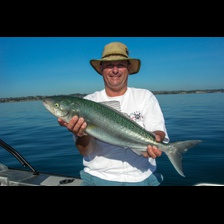

[2.9042021196801215e-06, 8.850642188917845e-06, 0.999860405921936, 2.4454120648442768e-05, 3.634782478911802e-05, 1.2094693374820054e-05, 1.7600636965653393e-06, 1.641627932258416e-05, 2.3921757019707e-06, 3.431203367654234e-05]


('australian_salmon', 0.999860405921936)

In [23]:
# ---------------

assert True # Change to True to run this

# ---------------

from PIL import Image
import requests
from io import BytesIO

image_url="https://www.fishing.net.nz/default/assets/Image/2017/catch-kahawai-03-558.jpg"

# Download an image from a URL
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))
tmp_local_path = "fish.jpg"

# And resize it
size = 224
new_im = Image.new('RGB', (size, size), (0, 0, 0, 0))
img.thumbnail([size, size])
(w, h) = img.size
new_im.paste(img, (int((size - w) / 2), int((size - h) / 2 )))
new_im.save(tmp_local_path, "JPEG", quality = 95)

# Show it
from IPython.display import Image, display
display(Image(filename=tmp_local_path))

# Classify it
classify_deployed(tmp_local_path, class_labels)

### (Optional) Perform Hyperparameter Tuning

Often, you might not know which values for hyperparameters like `learning_rate` and `mini_batch_size` will yield acceptible results. Traditionally, this meant manually running many training jobs with different hyperparameter values, looking at each trained model's performance, and then picking a winner. 


This type of manual tuning is _very_ time consuming, so you can automate this process using automatic model tuning with SageMaker. Here's some example code to illustrate how to start one of these jobs using the SageMaker Python SDK.

In [34]:
# ---------------

assert True # Change to True to run this

# ---------------
from sagemaker.tuner import HyperparameterTuner, IntegerParameter, CategoricalParameter, ContinuousParameter
hyperparameter_ranges = {
    'optimizer': CategoricalParameter(['sgd', 'adam', 'rmsprop', 'nag']),
     'learning_rate': ContinuousParameter(0.0001, 0.1),
     'mini_batch_size': CategoricalParameter([4, 8, 16]),
     'momentum': ContinuousParameter(0.0, 0.99),                                                                   
     'weight_decay': ContinuousParameter(0.0, 0.99),   
}

objective_metric_name = 'validation:accuracy'

tuner = HyperparameterTuner(
    image_classifier,
    objective_metric_name,
    hyperparameter_ranges,
    early_stopping_type='Off',
    max_jobs=500,
    max_parallel_jobs=1
)


tuner.fit(inputs=data_channels, logs=True, include_cls_metadata=False)

## Cleaning Up

When you're done learning here, you'll likley want to delete the endpoint you deployed (if you did so), since that endpoint will charge you money even if you're not actively making inferences (because you're charged for the total availability time of the endpoint). Here's how to clean up the endpoint.

In [24]:
# ---------------

assert True # Change to True to run this

# ---------------
deployed_endpoint.delete_endpoint()

In [ ]:
# Code to load and run inference on ONNX model.

import onnx
import caffe2.python.onnx.backend
from caffe2.python import core, workspace

import numpy as np

# make input Numpy array of correct dimensions and type as required by the model

modelFile = onnx.load('model.onnx')
output = caffe2.python.onnx.backend.run_model(modelFile, inputArray.astype(np.float32))